<a href="https://colab.research.google.com/github/abhinai96/Image_Based_Search_Engine/blob/master/Image_base_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# New Section

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import numpy as np
import os
from keras.layers import Input, Dense, Conv2D,Reshape,Activation,LeakyReLU,Dropout,Flatten,Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.datasets import mnist
import cv2

In [3]:
img = cv2.imread(('/content/drive/My Drive/x_train/1.jpg'))# Reading the image from the google drive
IMG_SHAPE=img.shape
IMG_SHAPE

(512, 512, 3)

In [ ]:
dir_path=r'/content/drive/My Drive/x_train'
lst=[]
for i in os.listdir(dir_path):
    
 
    img=cv2.imread(dir_path+'//'+i)
    print(type(img))
    print(img.shape)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #img=img.astype('float32')/255 
    print(img.shape)
    lst.append(img)
lst

In [ ]:
import numpy
lst = numpy.array(lst)
lst

In [6]:
lst.shape

(1500, 512, 512, 3)

In [ ]:

# center images
lst = lst.astype('float32') / 255.0 
lst

In [8]:
from sklearn.model_selection import train_test_split
# split
X_train, X_test = train_test_split(lst, test_size=0.3, random_state=42)

In [10]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (1500, 512, 512, 3)


4

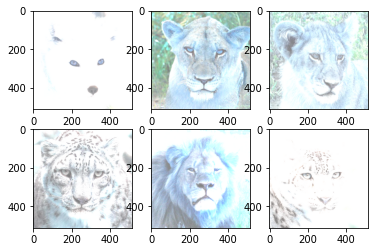

In [11]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(lst[i])

print("X shape:", lst.shape)
#print("attr shape:", attr.shape)

# try to free memory
del lst
import gc
gc.collect()

In [12]:
X_train.shape

(1050, 512, 512, 3)

In [ ]:
X_train[0]

In [14]:
input_dim=(512,512,3)#this is our input image shape
encoder_conv_filters=[32,64,64,64]
encoder_conv_kernel_size=[3,3,3,3]
encoder_conv_strides=[1,2,2,1]

decoder_conv_t_filters=[64,64,32,1]
decoder_conv_t_kernel_size=[3,3,3,3]
decoder_conv_t_strides=[1,2,2,1]



z_dim=2


In [15]:
encoder_input=Input(shape=input_dim,name='encoder_input')
n_layers_encoder=len(encoder_conv_filters)
x=encoder_input
for i in range(n_layers_encoder):
    conv_layer=Conv2D(
    filters=encoder_conv_filters[i]
    ,kernel_size=encoder_conv_kernel_size[i]
    ,strides=encoder_conv_strides[i]
    ,padding='same'
    ,name='encoder_conv_'+str(i)
    )
    x=conv_layer(x)
    x=LeakyReLU(name='leaky_relu'+str(i))(x)
shape_before_flattening=K.int_shape(x)[1:]
i=1 #this is merely for initialising a value to flatten layer name only
x=Flatten(name='flatten'+str(i))(x)
encoder_output=Dense(z_dim,name='encoder_output')(x)
encoder=Model(encoder_input,encoder_output)

In [16]:
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 512, 512, 32)      896       
_________________________________________________________________
leaky_relu0 (LeakyReLU)      (None, 512, 512, 32)      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 64)      18496     
_________________________________________________________________
leaky_relu1 (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_relu2 (LeakyReLU)      (None, 128, 128, 64)     

In [17]:
decoder_input=Input(shape=(z_dim,) ,name='decoder_input')
i=1   #intitlizing a vlaue for naming the dense layer
x=Dense(np.prod(shape_before_flattening),name='dense_'+str(i))(decoder_input)

x=Reshape(shape_before_flattening,name='reshape_'+str(i))(x)
n_layers_decoder=len(decoder_conv_t_filters)
for i in range(n_layers_decoder):
    
    conv_t_layer=Conv2DTranspose(
    filters=decoder_conv_t_filters[i]
    ,kernel_size=decoder_conv_t_kernel_size[i]
    ,strides=decoder_conv_t_strides[i]
    ,padding='same'
    ,name='decoder_conv_t_'+str(i)
    )
    x=conv_t_layer(x)
    
    if i<n_layers_decoder - 1:
        x=LeakyReLU(name='leaky_relu_'+str(i))(x)
    else:
        x=Activation('sigmoid')(x)
decoder_output=x
decoder=Model(decoder_input,decoder_output)

In [18]:
decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1048576)           3145728   
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 64)      0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_relu_0 (LeakyReLU)     (None, 128, 128, 64)      0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 256, 256, 64)      36928     
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 256, 256, 64)     

In [19]:
model_input=encoder_input
model_output=decoder(encoder_output)
model=Model(model_input,model_output)

In [20]:
optimizer=Adam(lr=0.0005)
def r_loss(y_true,y_pred):
    return K.mean(K.square(y_true - y_pred),axis=[1,2,3])
model.compile(optimizer=optimizer,loss=r_loss,metrics=['accuracy'])

In [21]:
X_train.shape

(1050, 512, 512, 3)

In [22]:
X_test.shape

(450, 512, 512, 3)

In [ ]:
model.fit(
x=X_train
,y=X_train,
validation_data=[X_test, X_test]
,batch_size=5
,shuffle=True
,epochs=10
)

In [ ]:
print(np.random.choice(range(len(X_test)),10))

[158  87 236  51  10  39 229  19 178 276]


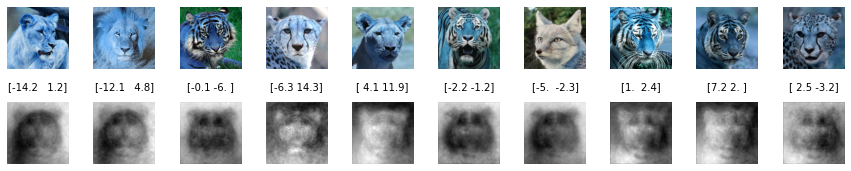

In [ ]:
n_to_show=10

example_idx=np.random.choice(range(len(X_test)),n_to_show)
example_images=X_test[example_idx]


z_points=encoder.predict(example_images)

reconst_images=decoder.predict(z_points)


fig=plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4,wspace=0.4)


for i in range(n_to_show):
    img=example_images[i].squeeze()
    ax=fig.add_subplot(2,n_to_show,i+1)
    ax.axis('off')
    ax.text(0.5,-0.35,str(np.round(z_points[i],1)),fontsize=10,ha='center',transform=ax.transAxes)
    ax.imshow(img,cmap='gray_r')
    
    
for i in range(n_to_show):
    img=reconst_images[i].squeeze()
    ax=fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

In [ ]:
images = X_train
codes = encoder.predict(images) 
assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
X_train.shape

(700, 512, 512, 3)

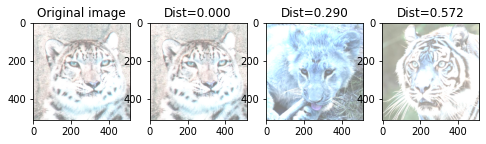

In [ ]:
# cherry picked smile images
show_similar(X_train[15])